### Inputs

In [262]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels
from statsmodels.tsa.stattools import adfuller as DickeyFuller
from statsmodels.tsa.stattools import pacf, acf
import itertools
import copy
import statistics
from functools import reduce
import pandas as pd


## Statistic metrics
#### MA, MSE, R^2, Durbin-Watson, variance, k-interval, Value-at-Risk

In [604]:
def MA(series, window = 5):
    series = np.cumsum(series)
    series[window:] = series[window:] - series[:-window]
    return series[window - 1:] / window

def MSE(series, predict):
    return np.sum((series-predict)**2)/len(series)

def SSE(series, predict):
    return np.sum((series-predict)**2)

def r2(predictions, y):
    l = len(predictions)
    avg = reduce(lambda v,w: v + w, y)/l
    dispersion = 0
    testDispersion = 0
    for i in range(l):
        dispersion += (y[i] - predictions[i])**2
        testDispersion += (y[i] - avg)**2
    r2 = (testDispersion/(testDispersion + dispersion)) ** 2
    return r2  

def DW(y, pred):
    e = list(np.array(y) - np.array(pred))
    sq = sum(list(map(lambda x: x**2, e)))
    diff = np.array(e[1:]) - np.array(e[:-1])
    diff = diff @ diff
    val = diff/sq
    return val

def variance(Y, length = 0):
    if length == 0:
        length = len(Y)
    if length == 1:
        return 1
    mean = 0
    variance = 0
    for i in range(len(Y)-length, len(Y)):
        mean += Y[i]
    mean /= length
    for i in range(len(Y)-length,len(Y)):
        variance += (Y[i] - mean)**2
    variance /= (- 1 + length)
    return variance

def k(interval):
    if interval == 0.95:
        return 1.65      
    elif interval == 0.99:
        return 2.33
    
    else:
        return interval


def VaR(value, var,  alpha = 0.05, verbose = False):    
    new_value = value*(1-np.exp(-(k(1-alpha)*var)))
    if verbose:
        print(new_value)
    return k(1-alpha)*var


def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))


def MAE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.average(np.average(np.abs(y_true - y_pred), axis = 0))

## ACF + PACF 

In [264]:
def define_orders(series, horizon_AR=10,horizon_MA = 10, limit=0.6, verbose = False):
    p = 0
    q = 0
    for i in range(horizon_MA - 1, 0, -1):
        if verbose:
            print('acf ', i, ' ', abs(r(series,i)))
            print('pacf ', i, ' ', abs(pacf_my(series,i)))
            
        if abs(r(series,i)) > limit and q == 0:
            q = i
            
    for i in range(horizon_AR - 1, 0, -1):        
        if abs(pacf_my(series,i)) > limit and p == 0:
            p = i 
        
    return p, q

def r(Y, k):
    mean = 0
    variance = 0
    r = 0
    for i in range(len(Y)):
        mean += Y[i]
    mean /= len(Y)
    
    #(N-1) * variance
    for i in range(len(Y)):
        variance += (Y[i] - mean)**2
    variance /= (len(Y) - 1)
    for i in range(k, len(Y)):
        r += (Y[i] - mean)*(Y[i - k] - mean)
    r /= variance
    return r / (len(Y) - 1)    

def pacf_my(Y, s):
    values = {}
    
    def F(k, j):
        if((k,j) in values.keys()):
            return values[(k,j)]
        else:
            if(k == 1 and j == 1):
                f = r(Y, 1)
            else:
                numenator = 0
                denumenator = 0

                for i in range(1, k):
                    numenator -= F(k - 1, i) * r(Y, k - i)
                    denumenator -= F(k - 1, i) * r(Y, i)
                numenator += r(Y, k)
                denumenator += 1

                f = numenator/denumenator

            if(k == j):
                values[(k, j)] = f
                return values[(k, j)]
            else:
                values[(k, j)] = F(k - 1, j) - f * F(k - 1, k - j)
                return values[(k, j)]
                        
    def G(k):
        if(k == 1):
            return r(Y, 1)
        else:
            numenator = 0
            denumenator = 0
        
            for i in range(1, k):
                
                numenator -= F(k - 1, i) * r(Y, k - i)
                denumenator -= F(k - 1, i) * r(Y, i)
            numenator += r(Y, k)
            denumenator += 1
            return numenator/denumenator 
    return G(s)

## ARIMA

In [269]:
def ARIMA_model(series,procent = '5%', horizon_ar = 15, horizon_ma = 10, pacf_limit= 0.4, 
                window = 5,  display_last = 200, to_plot = True, verbose = False):
    #
    current_series = series
    counter = 0
    while True:
        testDF = DickeyFuller(current_series)
        if testDF[0] > testDF[4][procent]:#гипотеза не прошла
            diff_series = current_series[1:] - current_series[:-1]
            current_series = diff_series
            counter += 1
        else:
            break
            
    if counter == 0:
        trend_predict = np.zeros(len(series))
        trend_coefs = []
    else:
        trend_data = np.array([np.power(np.arange(len(series)),i)  for i in range(counter+1)]).T
        trend_coefs = np.linalg.lstsq(trend_data, series,rcond = -1)[0]
        trend_predict = trend_data@trend_coefs.T
        
    diff = series - trend_predict
    p, q = define_orders(diff,horizon_AR = horizon_ar, horizon_MA = horizon_ma, limit = pacf_limit)
    if verbose:
        print('Trend order: ', counter)
        print('Order of AR: ', p)
        print('Order of MA', q)
    
    border_AR = max(p,q + window)  
    border_MA = border_AR - window + 1
    data_AR = np.array([diff[border_AR - i:-i-1] for i in range(p)]).T
    data_MA = np.array([MA(diff[border_MA - i:-i-1], window) for i in range(q)]).T
    
    if p == 0 and q == 0:
        print('p and q = 0')
        return trend_coefs, 0, 0
    if p == 0:
        data = data_MA 
    elif q == 0:
        data = data_AR
    else:
        data = np.hstack((data_AR,data_MA))
        
    coefs = np.linalg.lstsq(data,diff[border_AR + 1:], rcond=-1)[0]
    
    if p == 0:
        coefs_ma = coefs[p:]
        coefs_ar = []
    elif q == 0:
        coefs_ma = []
        coefs_ar = coefs[:p]
    else:
        coefs_ar = coefs[:p]
        coefs_ma = coefs[p:]
        
    diff_predict = data@coefs.T
    result = diff_predict + trend_predict[border_AR + 1:]
    if False:#not to_plot:
        plt.figure(figsize=(20,8))
        plt.plot(diff_predict)
        plt.plot(diff[border_AR + 1:])
        plt.title('Approximation with ARIMA(' + str(p) + ',' + str(counter) + ',' + str(q) + ')')
        plt.legend(['Approximation', 'Real values'])
        
    if to_plot:
        plt.figure(figsize=(20,8))
        plt.plot(result[-display_last:])
        plt.plot(series[-display_last:])# + border_AR + 1
        plt.title('Approximation with ARIMA(' + str(p) + ',' + str(counter) + ',' + str(q) + ')')
        plt.legend(['Approximation', 'Real values'])
        
    stats = {}
    stats['MSE'] = MSE(series[border_AR + 1:],result)            
    stats['Mean value'] = np.sum(series[border_AR + 1:])/len(series[border_AR + 1:])   
    stats['Median value'] = statistics.median(map(float, series[border_AR + 1:]))
    stats['Akaike criterion'] = 2*(p+q)-2*np.log(SSE(series[border_AR + 1:],result))
    stats['R^2'] = r2(result, series[border_AR + 1:])        
    stats['Durbin-Watson'] = DW(series[border_AR + 1:],result) 
    return trend_coefs, coefs_ar, coefs_ma, stats
    
def get_trend(coef_i, dot):
    trend = 0
    for i in range(len(coef_i)): 
        trend +=  dot**i * coef_i[i]
    return trend

def arima_predict(series, coef_tr, coef_ar, coef_ma, window = 5):
    #predicts 1 elem
    p = len(coef_ar)
    q = len(coef_ma)
    i_trend = len(coef_tr)
    series_v_trende = copy.copy(series)
    forecast = list(series)
    for i in range(len(series)):
        series_v_trende[i] = series[i] - get_trend(coef_tr, i)
    border_AR = max(p,q + window)  
    border_MA = border_AR - window + 1
    data_ma = MA(series_v_trende, window)
    predicted = 0
    for i in range(p):
        predicted += coef_ar[i]*series_v_trende[-i - 1]
    for i in range(q):
        predicted += coef_ma[i]*data_ma[- i  - 1]

    predicted += get_trend(coef_tr,len(series))
    return predicted

def ARIMA_adj_predict(data_train, data_test, pacf_lim = 0.2, verbose = False):
    #predicts several elems using adjusted arima model every time
    predicted_values = []
    n = len(data_train)
    m = len(data_test)
    train = np.array(data_train)
    
    if verbose:
        print("Iteration ", end = '')
        
    for i in range(m):
        if verbose:
            print(str(i+1) + " ",end='')
        coef_tr, coef_ar, coef_ma, stats = ARIMA_model(train, pacf_limit=pacf_lim, to_plot = False)
        predicted_values.append(arima_predict(train, coef_tr, coef_ar, coef_ma))
        train = np.append(train[1:],predicted_values[-1])
    mse =  MSE(np.array(predicted_values), np.array(data_test))
    mae = MAE(np.array(predicted_values), np.array(data_test))
    mape = MAPE(np.array(predicted_values), np.array(data_test))
    
    if verbose:
        print()
        print("MSE ", mse)
        print("MAE ", mae)
        print("MAPE", mape)
    return np.array(predicted_values), np.array([mse, mae, mape])

def ARIMA_multi_predict(data_train, data_test, pacf_lim = 0.2):
    #predicts several elems using the same arima model coefs every time
    predicted_values = []
    n = len(data_train)
    m = len(data_test)
    train = np.array(data_train)
    
    coef_tr, coef_ar, coef_ma, stats = ARIMA_model(train, pacf_limit=pacf_lim, to_plot = False)  
    print("Iteration ", end = '')
    for i in range(m):
        print(str(i+1) + " ",end='')
        predicted_values.append(arima_predict(train, coef_tr, coef_ar, coef_ma))
        train = np.append(train[1:],predicted_values[-1])
    print()
    print("MSE ", MSE(np.array(predicted_values), np.array(data_test)))
    print("MAE ", MAE(np.array(predicted_values), np.array(data_test)))
    print("MAPE", MAPE(np.array(predicted_values), np.array(data_test)))
    return np.array(predicted_values)

In [1]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import datetime    
from hurst import compute_Hc, random_walk

In [768]:

%%time
company = "INTC"
start = pd.Timestamp("1980-03-28")
end = pd.Timestamp("2020-11-28")
df = pd.DataFrame(columns=['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'])
df = web.DataReader(company, 'yahoo', start, end)
#df.to_csv("df.csv")
#df.info()

pivot_val="2020-7-27"
pivot_test="2020-7-28"
pred_col="Open"
    
def compute_hurst(series):
    series = series.apply(np.exp)
    H, c, data = compute_Hc(series, kind='change', simplified=True)
    return H

#df["hurst_100"] = df[pred_col].rolling(100).apply(compute_hurst)
df.dropna(inplace=True)

_train = df[df.index < pd.Timestamp(pivot_val)]

_val = df[(df.index > pd.Timestamp(pivot_val)) & (df.index < pd.Timestamp(pivot_test))]

_test = df[df.index > pd.Timestamp(pivot_test)]

CPU times: user 211 ms, sys: 143 ms, total: 354 ms
Wall time: 1.39 s


In [771]:

y_train = np.array(_train['Open'])
y_test = np.array(_test['Open'])
y_all = np.append(y_train,y_test)
n = len(y_train)
m = len(y_test)


In [772]:
def windows_walk(train, test, pacf_lim = 0.2, window = 5, train_num = 50):
    y_all = np.append(train,test)
    n = len(train)
    m = len(test)
    forecasts = []
    statist = []
    for i in range(m//window):
        y_trainer = y_all[n - train_num + i*window: - m + i*window ]
        y_tester = test[i*window:(i+1)*window ]
        forecast, stat = ARIMA_adj_predict(y_trainer, y_tester, pacf_lim = pacf_lim)
        forecasts.append(forecast)
        statist.append(stat)
        
    return np.array(forecasts), np.array(statist)


def var_borders(prev_data, test_for, alpha = 0.05, window = 10):
    mean_val = []
    gauss_val = []
    for i in range(window):
        mean_val.append(np.mean(np.append(prev_data,test_for[:i+1])[-window:]))
        stand_deriviation = np.sqrt(variance(np.append(prev_data,test_for[:i+1])[-2*window:]))
        exp_value = np.average(np.append(prev_data,test_for[:i+1])[-2*window:])
        gauss_val.append(k(1-alpha)*stand_deriviation/exp_value)
    
    return np.array(mean_val), np.array(gauss_val)

In [773]:
np.average(statist[:,0]),np.average(statist[:,1]),np.average(statist[:,2])

(9.599185161760337, 2.1899424092629105, 0.042983652934558525)

In [809]:
_test['Open'][::10]

Date
2020-07-29    49.490002
2020-08-12    48.669998
2020-08-26    49.389999
2020-09-10    50.000000
2020-09-24    48.529999
2020-10-08    52.910000
2020-10-22    53.119999
2020-11-05    46.150002
2020-11-19    44.919998
Name: Open, dtype: float64

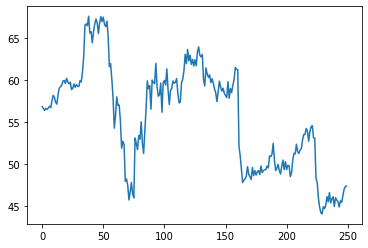

In [667]:
plt.plot(y_all[-250:])

In [774]:
arimas_forecast, arimas_stats = windows_walk(y_train,y_test, window = 10, train_num = 40, pacf_lim=0.25)

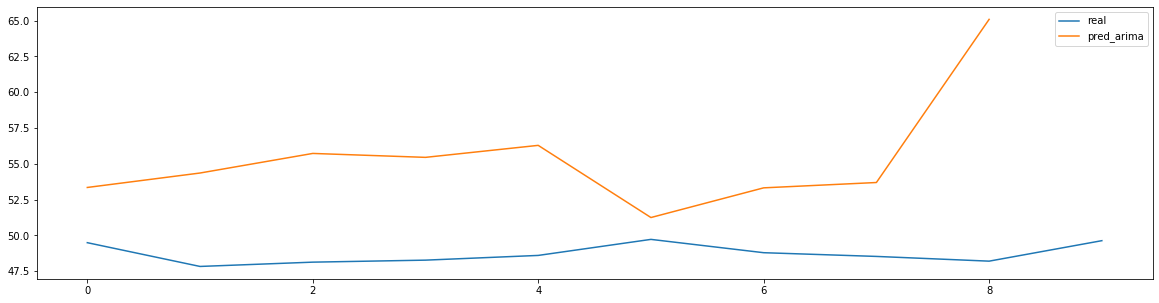

In [776]:
windows = 10
k = 0
plt.figure(figsize = (20, 5))
plt.plot(y_test[windows*(k):windows*(k+1)], label = 'real')
plt.plot(arimas_forecast[k][:-1], label = 'pred_arima')
plt.legend()

In [841]:
np.average(np.array(losses)[1:])

2.251904054441758

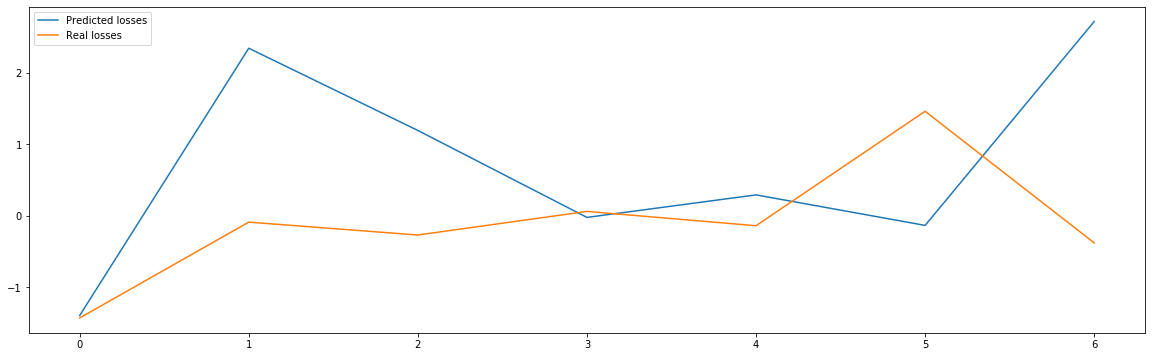

In [806]:

plt.figure(figsize = (20, 6))
plt.plot(losses, label = 'Predicted losses')
plt.plot(real_losses, label = 'Real losses')
plt.legend()